In [139]:
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
from sklearn.model_selection import train_test_split
import nltk
import re
import scipy.stats as scistat
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re
import statistics as stat

In [140]:
parquet_file1 = "Transacation_inflows_with_date_3k.pqt"

inflow = pd.read_parquet(parquet_file1, engine='pyarrow')

In [141]:
inflow

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,METROPOLITAN REG PAYROLL PPD ID: XXXXXXXXXX,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,ONSTAR SERVICES 888-4ONSTAR MI 08/25,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,Zelle payment from CHRISTOPHER J LYONS XXXXXXX...,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,METROPOLITAN REG VENDOR XXXXXX CCD ID: XXXXXXXXXX,100.00,2022-07-29,EXTERNAL_TRANSFER
...,...,...,...,...,...,...
1035832,5941,acc_9524,POS DEPOSITUber 182 Howard St. San Francisco C...,8.66,2023-01-21,EXTERNAL_TRANSFER
1035833,5941,acc_9524,POS DEPOSITUber 182 Howard St. San Francisco C...,267.13,2023-01-23,EXTERNAL_TRANSFER
1035834,5941,acc_9524,ACH DEPOSIT RAISER XXXXTYPE: EDI PAYMNT DATA: ...,2.00,2023-01-24,EXTERNAL_TRANSFER
1035835,5941,acc_9524,POS DEPOSITUber 182 Howard St. San Francisco C...,207.16,2023-01-24,EXTERNAL_TRANSFER


# A Look Into the Inflow Dataset

In [142]:
#income per consumer stats
inflow.groupby('prism_consumer_id')['amount'].sum().describe()

count    2.974000e+03
mean     1.267604e+05
std      3.005366e+05
min      2.400000e-01
25%      2.589696e+04
50%      5.684713e+04
75%      1.353733e+05
max      1.032516e+07
Name: amount, dtype: float64

In [143]:
#transactions by consumer stats
inflow.groupby('prism_consumer_id')['amount'].count().describe()

count    2974.000000
mean      172.533625
std       148.452108
min         1.000000
25%        78.000000
50%       134.000000
75%       219.000000
max      1765.000000
Name: amount, dtype: float64

In [144]:
#count category breakdown 
inflow.groupby('category')['amount'].count()#.describe()

category
DEPOSIT                   61345
EXTERNAL_TRANSFER        156533
INSURANCE                   174
INVESTMENT_INCOME         17325
LOAN                       2513
MISCELLANEOUS             55648
OTHER_BENEFITS             7708
PAYCHECK                  33138
PAYCHECK_PLACEHOLDER      26087
REFUND                    23220
SELF_TRANSFER            110437
SMALL_DOLLAR_ADVANCE      13621
TAX                        3405
UNEMPLOYMENT_BENEFITS      1961
Name: amount, dtype: int64

In [145]:
#amount category breakdown
inflow.groupby('category')['amount'].sum()#.describe()

category
DEPOSIT                  66602343.60
EXTERNAL_TRANSFER        81586232.14
INSURANCE                  338514.02
INVESTMENT_INCOME         6887278.35
LOAN                      4231710.73
MISCELLANEOUS            52594312.59
OTHER_BENEFITS           12175837.46
PAYCHECK                 54018520.29
PAYCHECK_PLACEHOLDER     35706161.73
REFUND                    5406440.27
SELF_TRANSFER            48301522.92
SMALL_DOLLAR_ADVANCE      1906595.47
TAX                       5619601.78
UNEMPLOYMENT_BENEFITS     1610419.79
Name: amount, dtype: float64

In [146]:
inflow[inflow['category'] == 'EXTERNAL_TRANSFER'].sort_values(by = 'amount', ascending = False)

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
12620,62,acc_172,FEDWIRE CREDIT VIA: SILICON VALLEY BANK/XXXXXX...,1154965.83,2022-04-05,EXTERNAL_TRANSFER
8245,37,acc_100,WT FED#XXXXX SILICON VALLEY BAN /ORG=WAYFLYER ...,1000000.00,2021-04-07,EXTERNAL_TRANSFER
74027,376,acc_1113,WT FED#XXXXX SOUTH STATE BANK /ORG=U STAR INC ...,521639.97,2022-06-21,EXTERNAL_TRANSFER
244830,1288,acc_3610,Incoming Wire Transfer,437036.08,2021-08-09,EXTERNAL_TRANSFER
244851,1288,acc_3610,Incoming Wire Transfer,421051.22,2022-02-10,EXTERNAL_TRANSFER
...,...,...,...,...,...,...
563296,3220,acc_6803,Visa money transfer,0.01,2023-05-04,EXTERNAL_TRANSFER
412131,2264,acc_5847,Visa money transfer,0.01,2022-10-20,EXTERNAL_TRANSFER
618347,3590,acc_7173,Brigit New York NYUSXXXXX Credit - MoneySend,0.01,2023-05-18,EXTERNAL_TRANSFER
427331,2356,acc_5939,Person to Person Credit Brigit New York NY 00E...,0.01,2022-07-11,EXTERNAL_TRANSFER


In [147]:
inflow[inflow['category'] == 'DEPOSIT'].sort_values(by = 'amount', ascending = False)

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
330657,1769,acc_4902,Deposit,640000.00,2023-02-16,DEPOSIT
106919,541,acc_1593,Deposit,414295.86,2021-10-08,DEPOSIT
248510,1308,acc_3662,DEPOSIT ID NUMBER XXXXX,392733.02,2021-09-07,DEPOSIT
88155,449,acc_1322,Deposit,390000.00,2022-01-21,DEPOSIT
95384,489,acc_1428,DEPOSIT XXXXXXXXX,363707.35,2023-01-17,DEPOSIT
...,...,...,...,...,...,...
440558,2422,acc_6005,Brigit Brigit - Deposit Account,0.01,2023-07-03,DEPOSIT
442101,2438,acc_6021,ATM P to P Credit Brigit NEW YORK NY #XXXX,0.01,2022-12-29,DEPOSIT
442599,2442,acc_6025,DEBIT CARD CREDIT Brigit New York NY Ref:XXXXX...,0.01,2022-10-28,DEPOSIT
443347,2445,acc_6028,Deposit,0.01,2022-09-20,DEPOSIT


# Processing

In [148]:
#preprocessing memo text to maintain details but not exact dates/numbers, etc

inflow['memo'] = inflow['memo'].str.lower().apply(lambda x: re.sub(r'\b(\w*\d+\w*)\b', 'X', x))
inflow['category'] = inflow['category'].str.lower()

In [159]:
#these categories are always going to be considered part of income
paycheck_inflow = inflow[inflow['category'].isin(['paycheck', 'paycheck_placeholder'])]
paycheck_inflow['age'] = -1

#these categories will be considered income if we can find a time recurrent pattern or an amount recurrent pattern
categories_of_interest = ['deposit', 'external_transfer', 'investment_income', 'unemployment_benefits', 'miscellaneous']
rel_inflow = inflow[inflow['category'].isin(categories_of_interest)]
rel_inflow['category'] = rel_inflow['category'].str.lower()

/tmp/ipykernel_223/797154290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paycheck_inflow['age'] = -1
/tmp/ipykernel_223/797154290.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_inflow['category'] = rel_inflow['category'].str.lower()


In [150]:
#Function to find the transactions for a given user for a given category
#Parameters:
#  user: user of interest string 
#  category: category of interest string

def user_transactions_by_category(user, category):
    trans = rel_inflow[(rel_inflow['prism_consumer_id'] == user) & (rel_inflow['category'] == category)].sort_values(by='posted_date')
    return trans

In [151]:
rel_inflow

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
1,0,acc_0,metropolitan reg vendor xxxxxx ccd id: xxxxxxxxxx,100.00,2022-10-25,external_transfer
2,0,acc_0,onstar services X-X mi X/X,6.29,2022-08-26,miscellaneous
3,0,acc_0,zelle payment from christopher j lyons xxxxxxx...,277.00,2022-06-03,external_transfer
4,0,acc_0,metropolitan reg vendor xxxxxx ccd id: xxxxxxxxxx,100.00,2022-07-29,external_transfer
5,0,acc_0,metropolitan reg vendor xxxxxx ccd id: xxxxxxxxxx,100.00,2022-12-23,external_transfer
...,...,...,...,...,...,...
1035832,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,8.66,2023-01-21,external_transfer
1035833,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,267.13,2023-01-23,external_transfer
1035834,5941,acc_9524,ach deposit raiser xxxxtype: edi paymnt data: ...,2.00,2023-01-24,external_transfer
1035835,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,207.16,2023-01-24,external_transfer


In [152]:
#Function to find the earliest transaction for a given user for a given category
#to be used after user_transactions_by_category
#Parameters:
# trans: dataframe of transactions given
def earliest_by_category(trans):
    earliest= trans.iloc[0]['posted_date']
    return earliest

In [161]:
#Code iterates over users in inflow dataframe for relevant categories
#for each user, we check each category and find the earliest transaction
# populates user dictionary with dictionary of earliest transaction by category

earliestByUserByCategory  = dict()
for user in rel_inflow['prism_consumer_id'].unique():
    earliestByUserByCategory[user] = dict()
    for cat in categories_of_interest:
        curr_category_transactions = user_transactions_by_category(user, cat)
        if len(curr_category_transactions) == 0:
            continue
        else:
            earliestByUserByCategory[user][cat] = earliest_by_category(curr_category_transactions)
        

In [162]:
#Function calculates the age of a transaction by earlies transaction within same category
#Parameter:
# transac: singlular transaction of interest
def age(transac):
    cat = transac['category']
    first_date = earliestByUserByCategory[transac['prism_consumer_id']][cat]
    curr = transac['posted_date']
    return (curr - first_date).days
    

In [164]:
#applyies age function to create new column
rel_inflow['age'] = rel_inflow.apply(age, axis=1)



/tmp/ipykernel_223/1541804394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_inflow['age'] = rel_inflow.apply(age, axis=1)


# Age Feature Exploration

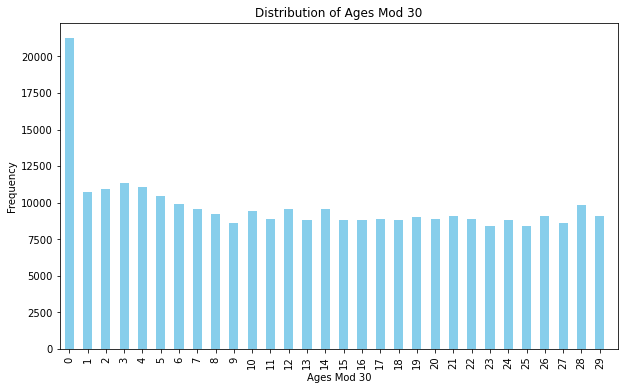

In [223]:
def mod30(transac):
    age  = transac['age']
    return age % 30

def mod7(transac):
    age  = transac['age']
    return age % 7


plt.figure(figsize=(10, 6))
rel_inflow.apply(mod30, axis = 1).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ages Mod 30')
plt.xlabel('Ages Mod 30')
plt.ylabel('Frequency')
plt.xlim(right=30)
plt.show()

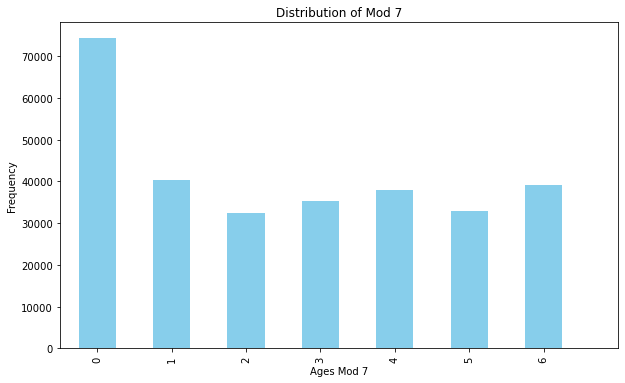

In [222]:
plt.figure(figsize=(10, 6))
rel_inflow.apply(mod7, axis = 1).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Mod 7')
plt.xlabel('Ages Mod 7')
plt.ylabel('Frequency')
plt.xlim(right=7)
plt.show()

# Model Logic

In [167]:
#average recurrence of transactions

#Parameter:
# trans: transaction dataframe for all transactions grouped together (same min)

def mod_avg_transaction_recurrence(trans):
    ages = trans.sort_values(by = 'age')['age']
    differences = np.diff(ages)
    return sum(differences)/len(differences)


In [168]:
#should grab amounts within same memo that are similar
#meant to differentiate between transactions that might have the same memo but are for very different amounts, ie no longer part
#of the same transaction set

#Function returns all groups with values within 10% 

#Parameter:
# lst: list of amounts for transactions with same memo but not same amounts 

def group_values(lst):
    groups = []
    
    for value in lst:
        added_to_existing_group = False

        for group in groups:
            median = stat.mean(group)
            # Check if the current value is within 10% of any value in the group or the median
            if any(0.9 * x <= value <= 1.1 * x for x in group) or (median and 0.9 * median <= value <= 1.1 * median):
                group.append(value)
                added_to_existing_group = True
                break

        if not added_to_existing_group:
            # Start a new group with the current value
            groups.append([value])

    # Include groups with at least one element
    groups = [group for group in groups if len(group) >= 1]

    return groups

In [169]:
#support function for determine_income, determines whether transactions are recurrent enough

#Parameters:
# trans: dataframe of associated transactions
def regular_time(trans):
    metric = mod_avg_transaction_recurrence(trans)
        
    #highly frequent transactions should have a higher # of repetitions to ensure large span of time (more likely income than random deposits)
    #sparsely frequent transactios can have fewer repetitions but still represent a large span of time

    if (metric >=7) & (metric <=16):
        recurr = (len(trans) >= 4) #placeholder (equivalent of min 28 days span of time)
            
    elif (metric <= (31 + 3)) & (metric > 16):
        recurr = (len(trans) >= 2) #placeholder (equivalent of min 33 days of time)
    else:
        recurr = False

    return recurr
    
    
    


In [172]:
#Logic: transaction with repeat memos can be income if reccurent every month or so,
#


#Function will determine which undetermined transactions should be considered income

#column populates Nonetypes for all transactions, to be overwritten by boolean for whether transactions are considered income or not
rel_inflow['recurring_flag'] = None


def determine_income(userID):

    user_trans = rel_inflow[rel_inflow['prism_consumer_id']==userID]
    #memo dependent repetition
    repeat_memos = user_trans.groupby("memo")[['age']].count()
    memo_list = repeat_memos[repeat_memos['age']>1].index
    

    for memo in memo_list:
        repeat = user_trans[user_trans['memo'] == memo]
        amounts = list(repeat['amount'])
        
        #check whether all values are close enough (ie confident same transactions)
        med_val = stat.median(amounts)
        
        
        #if amounts close enough, check recurrence is often enough to be the same source
        if all(abs(med_val - x) / x <= 0.1 for x in amounts): 
            
            recurr = regular_time(repeat)

            # Update the 'recurring_flag' column in the original dataframe (rel_inflow) based on the condition
            rel_inflow.loc[(rel_inflow['prism_consumer_id'] == userID) & (rel_inflow['memo'] == memo), 'recurring_flag'] = recurr


        #if amount isnt close enough, investigate each subgroup (grouped by amount +/- 10%)
        else:
            transaction_groups = group_values(amounts)
            for group in transaction_groups:
                if len(group)>=2:
                    repeat_subset = repeat[repeat['amount'].isin(list(set(group)))]
                    indxs = repeat_subset.index
                    recurr = regular_time(repeat_subset)
                    
                    # Update the 'recurring_flag' column in the original dataframe (rel_inflow) based on the condition
                    rel_inflow.loc[(rel_inflow['prism_consumer_id'] == userID) & (rel_inflow['memo'] == memo) & rel_inflow.index.isin(indxs),'recurring_flag'] = recurr
        
    
    ##same amount, regardless of memo
    #for each category in transactions
    #groupby amount 
    #check recurrence 
    for cat in ['deposit', 'external_transfer', 'investment_income', 'unemployment_benefits', 'miscellaneous']:
        user_cat_trans = user_trans[user_trans['category'] == cat] 
        repeat_amount = user_cat_trans.groupby("amount")[['age']].count()
        amount_list = repeat_amount[repeat_amount['age']>1].index
        
        for val in amount_list:
            repeat = user_trans[user_trans['amount'] == val]
            
            recurr = regular_time(repeat)

            condition = (rel_inflow['prism_consumer_id'] == userID) & (rel_inflow['amount'] == val) & (rel_inflow['recurring_flag'].isin([False, None]))

            rel_inflow.loc[condition, 'recurring_flag'] = recurr
        
           
    

/tmp/ipykernel_223/2905025699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_inflow['recurring_flag'] = None


In [173]:
for u in rel_inflow.groupby('prism_consumer_id').count().index:
    determine_income(u)

In [175]:
paycheck_inflow['recurring_flag'] = True
flagged_income = rel_inflow[rel_inflow['recurring_flag']==True]

/tmp/ipykernel_223/3717440678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paycheck_inflow['recurring_flag'] = True


In [177]:
income = pd.concat([paycheck_inflow, flagged_income])
income

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,age,recurring_flag
0,0,acc_0,metropolitan reg payroll ppd id: xxxxxxxxxx,2477.02,2022-03-18,paycheck,-1,True
6,0,acc_0,metropolitan reg payroll ppd id: xxxxxxxxxx,2547.35,2023-02-03,paycheck,-1,True
16,0,acc_0,metropolitan reg payroll ppd id: xxxxxxxxxx,2528.40,2022-10-20,paycheck,-1,True
17,0,acc_0,metropolitan reg payroll ppd id: xxxxxxxxxx,2547.35,2023-01-20,paycheck,-1,True
25,0,acc_0,metropolitan reg payroll ppd id: xxxxxxxxxx,2331.71,2022-05-05,paycheck,-1,True
...,...,...,...,...,...,...,...,...
1035820,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,240.00,2023-01-14,external_transfer,196,True
1035821,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,33.03,2023-01-14,external_transfer,196,True
1035825,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,73.78,2023-01-18,external_transfer,200,True
1035827,5941,acc_9524,pos deposituber X howard st. san francisco ca ...,112.46,2023-01-19,external_transfer,201,True


In [178]:
estimated_income = income.groupby('prism_consumer_id')['amount'].sum()

In [204]:
#since not all users had transactions for the categories of interest
missing_set = set(inflow['prism_consumer_id'].unique()) - set(estimated_income.index)
for ID in missing_set:
    estimated_income[ID] = 0

# Results Described

In [205]:
estimated_income.describe()

count    2.974000e+03
mean     4.933385e+04
std      8.290618e+04
min      0.000000e+00
25%      1.143620e+04
50%      2.442624e+04
75%      6.387385e+04
max      1.939611e+06
Name: amount, dtype: float64

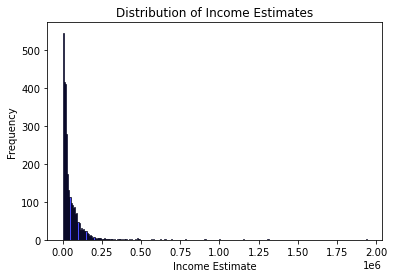

In [206]:
plt.hist(estimated_income, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Income Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of Income Estimates')

# Show the plot
plt.show()

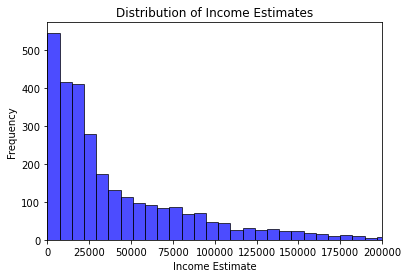

In [207]:
plt.hist(estimated_income, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.xlim(0, 200000)
# Add labels and title
plt.xlabel('Income Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of Income Estimates')

# Show the plot
plt.show()

In [215]:

'''
Function estimates the yearly income for each user
'''
def estimate_yearly_income(df, income_estimate):
    def time_frame(userID, df):
        trans = df[df['prism_consumer_id']==userID].sort_values(by='posted_date')['posted_date']
        if len(trans) ==1:
            return 0
        else:
            first_date = trans.iloc[0]
            last_date = trans.iloc[-1]
            return (last_date - first_date).days
    
    annual_income = pd.Series()
    for userID in income_estimate.index:
        
        income = income_estimate.loc[userID]
        
        if income != 0:
        
            time_span = time_frame(userID, df)
            if time_span != 0:
                estimated_annual_income = (income / time_span) * 365
            else:
                estimated_annual_income = income
            annual_income[userID] = estimated_annual_income
        else:
            annual_income[userID] = 0
          
    return annual_income


In [216]:
annual = estimate_yearly_income(inflow, estimated_income)

In [217]:
annual.describe()

count    2.974000e+03
mean     5.486543e+04
std      7.737935e+04
min      0.000000e+00
25%      1.804886e+04
50%      3.831677e+04
75%      6.668672e+04
max      1.950298e+06
dtype: float64

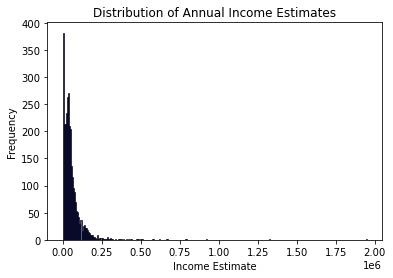

In [218]:
plt.hist(annual, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Income Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income Estimates')

# Show the plot
plt.show()

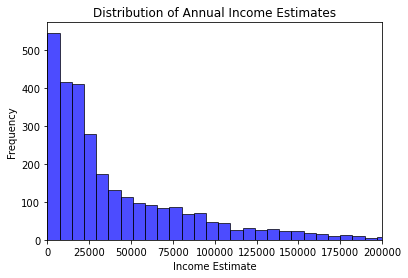

In [219]:
plt.hist(estimated_income, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.xlim(0, 200000)
# Add labels and title
plt.xlabel('Income Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income Estimates')

# Show the plot
plt.show()